<a href="https://colab.research.google.com/github/Krisss993/GAN/blob/main/06_13_GAN_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import pdb
from torch.utils.data import DataLoader

# nn architecture
from torch import nn
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid

# progress bar
from tqdm.auto import tqdm

In [ ]:
x = np.arange(start=0.01, stop=1.01, step=0.01)
y = -np.log(x)

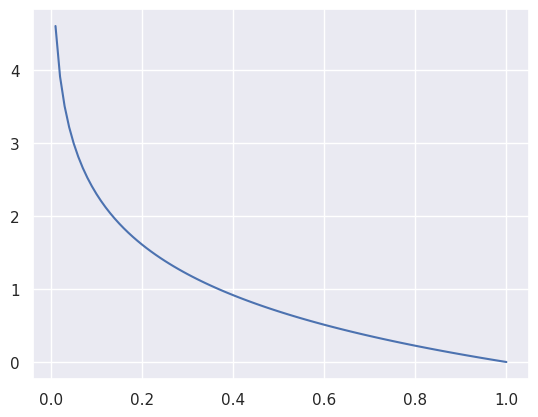

In [ ]:
plt.plot(x,y)

In [ ]:
np.log2(0.05)

-4.321928094887363

In [ ]:
np.log(0.05)

-2.995732273553991

In [ ]:
0.9*0.045+0.05*1.3+0.05*1.3

0.1705

In [1]:
!nvidia-smi

Thu Jun 13 07:44:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Visualization function

In [7]:
# ch - channels(colors, 1=greyscale)
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784
  # 128 - batch size, 784 - size=(28,28)

  # detach variable from the computation of the gradient
  # cpu - return back engine from gpu
  # view - reshapes to -1(128) x 1 x 28 x 28
  # -1 - remaining size(128)
  data = tensor.detach().cpu().view(-1,ch,*size)

  # grid takes first 16 elements from data
  # permute - allows to change order of the channels(dimensions)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  # pytorch make_grid returns: 16 x 1 x 28 x 28, every image has size of: 1(ch) x 28(w) x 28(h)
  # for matplotlib we need to change dimensions to 28(w) x 28(h) x 1(ch)
  plt.imshow(grid)
  # plt.axis('off')
  plt.show()

In [8]:
# the number times that the learning algorithm will work through the entire training dataset
epochs = 500
cur_step = 0

#
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

# hyperparameters

# dimensionality of a noise vector(input of the generator)
z_dim = 64
# rate at which nn tweaks the parameters, pushing them in the direction of the negative gradient
lr = 0.00001
# BCELoss - calculates the loss
# BCEWithLogitsLoss - converts the output of the discriminator the num values in the range 0 to 1(sigmoid function),
# before calculating loss, then it calculates the loss
loss_func = nn.BCEWithLogitsLoss()

# batch_size - how many images are we going to process at once, during each step of the training
bs = 128
device = 'cuda'

# structure holding training data, iterator that gives back batches of the training data with set of elements and labels
# root - where to store the data
# transform - after downloading to root folder transform ToTensor
# ToTensor - multidimensional tensor
# shuffle - in every epoch changes the order of the data
dataloader = DataLoader(FashionMNIST(root='.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

# number of steps per epoch: 60000 / 128 = 468.75

100%|██████████| 26421880/26421880 [00:06<00:00, 3995193.75it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202497.93it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3912626.19it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15534012.22it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [9]:
# Generator

def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      # inplace=True - modifies input directly, without alocating extra resources, lowers memory usage
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  # z_dim - input noise latent vector dim
  # i_dim - output, size of the image
  # h_dim - size of first hidden layer

  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(

        # input is noise, output is size of the first hidden layer
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256, 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)

        # returns output to vals in range 0-1
        nn.Sigmoid()
    )

  # executed after running instance of the class
  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  # returns standarized random vector of given size and puts it into gpu
  return torch.randn(number, z_dim).to(device)

When we call an instance of the Generator - forward - we call it with a noise vector and then Gen class returns the retults of passing that noise vector or vectors(number - size of the batch) of a given shape(z_dim) through its Sequential structure.

In [10]:
# Discriminator

def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      # to avoid the death of number of neurons by changing them to 0(standard RELU), it gives them small negative value
      # on a certain slope - 0.2
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  # input to the discriminator is an image, size 28x28(784)
  # output - default size of a hidden layer fe. 256
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
    return self.disc(image)

Disc returns 1 if it predicts real image or 0 if it predicts false.
When we call an instance - forward - with an image, it returns retult of passing that image through all sequential layers of that model.

In [11]:
# z_dim - size of the noise vector
# device - cuda
gen = Generator(z_dim).to(device)

# optimizer calculates the gradient with backpropagation and updates parameters
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)


disc = Discriminator().to(device)

disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

track_running_stats - track statistics of the batch(mean, variance) during all the training process;
affine - using affine learning parameters;
BatchNorm - normalizes the parameters ;
momentum -

In [17]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [21]:
# returns whole next batch
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

# x - 128 pictures of size 1 x 28 x 28 (shape)
# y - 128 labels (shape)
# y[:10] - 10 labels

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 6, 1, 2, 8, 0, 5, 5, 7, 5])


In [23]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 8, 0, 7, 9, 4, 4, 6, 2, 3])


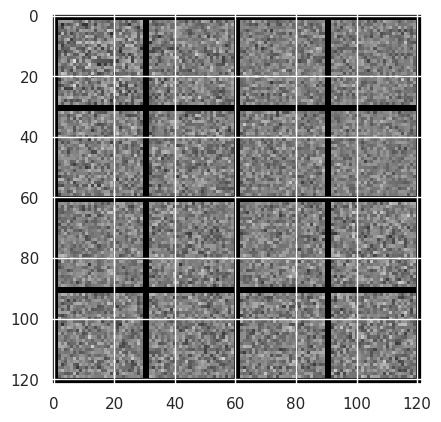

In [29]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)
# initial output of the generator without learning

In [32]:
fake[100,100]

tensor(0.7418, device='cuda:0', grad_fn=<SelectBackward0>)

In [1]:
# calculating the loss
# generator loss

def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  # noise vector - input of the generator, number - size of the batch, z_dim - input noise latent vector dim
  noise = gen_noise(number, z_dim)

  # passing set(batch size set) of the vectors through generator class instance
  fake = gen(noise)

  # passing fake set of images to the discriminator, obtaining the predictions from the discriminator, wheather it
  # predict it to be fake or real
  pred = disc(fake)

  # creating vector(tensor) of ones of size of pred
  targets = torch.ones_like(pred)

  # comparing predictions with targets(real images-ones)
  gen_loss = loss_func(pred, targets)
  return gen_loss

In [3]:
# discriminator loss
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake =  gen(noise)

  # passing fake images generated by the generator through the discrimiator
  # detach separates fake images from the calculation of the gradient by the generator
  disc_fake = disc(fake.detach())

  # creating vector(tensor) of zeroes of size of pred
  disc_fake_targets = torch.zeros_like(disc_fake)

  # comparing output of the discriminator to the targets
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  # passing real images passed through discriminator
  disc_real = disc(real)

  # targets as ones
  disc_real_targets = torch.ones_like(disc_real)

  # comapring output of the discriminator with the targets - ones
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss=(disc_fake_loss+disc_real_loss) / 2

  return disc_loss

In [12]:
for epoch in range(epochs):
  # passing real images, _ is for labels which is not needed
  for real, _ in tqdm(dataloader):




    ### discriminator

    # first, take the discriminator optimizer and set its gradient to zero
    disc_opt.zero_grad()

    # current batch size
    # batch size - len(real) is mostly 128, but in last step it may be smaller
    cur_bs = len(real) # 128 x 1 x 28 x 28

    # reshaping real images to the size of the batch, concentrating other dimensions
    # keeping size of the batch, but flattening other dimensions
    real = real.view(cur_bs, -1) # 128 x 784

    # storing images to gpu
    real = real.to(device)

    # calculation the loss function
    disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

    # backpropagation
    # retain_graph - keeping graph in memory to be accesable
    disc_loss.backward(retain_graph=True)

    disc_opt.step()





    ### generator

    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()





    ### visualization & stats

    # accumulating losses and dividing them by info_step(300 steps)
    # .item() transforms tensor to standalone number
    mean_disc_loss += disc_loss.item() / info_step
    mean_gen_loss += gen_loss.item() / info_step

    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f'Epoch: {epoch}, step: {cur_step} /// Gen loss: {mean_gen_loss}, Disc loss: {mean_disc_loss}')
      mean_disc_loss = 0
      mean_gen_loss = 0
    cur_step+=1

  0%|          | 0/469 [00:00<?, ?it/s]

NameError: name 'disc_opt' is not defined